# Exploring Clustering with K-Means

***Note:*** The underlying algorithm I wrote to support this notebook is not public as requested by my professor. I would be happy to share or discuss in a private setting.

### What is clustering?

 - A type of unsupervised learning (labels not provided to model)
 - Data partitioned into distinct groups
 - Groups iteratively improved 
 - Goal: Observations in the same cluster are more similar, observations in different clusters are more different

In [1]:
%run kmeans

## K-means Algorithm

K-means begins by initializing k centroids (cluster centers) where k is the number of desired output clusters. There are two methods to initialize centroids, randomly and with kmeans++. The next two steps are performed iteratively to continually improve upon the centroids until there is little change between the previous and current centroids. Points are assigned to clusters by finding the centroid that the point is closest to; the mean of each cluster then become the new centroids.

In [20]:
# Quick gut check of algorithm
grades = np.array([92.65, 93.87, 74.06,86.94,92.26,94.46,92.94, 80.65, 92.86, 85.94, 
                   91.79, 95.23, 85.37, 87.85, 87.71, 93.03]).reshape(-1,1)
centroids,labels=kmeans(grades,3)

In [21]:
# Compare to quantile values
quant_33 = np.quantile(grades,.33)
quant_66 = np.quantile(grades,.66)

# Provide tolerance (+-1) to check centroids since clusters generated may not always be the same
assert(min(grades)<=sorted(np.round(centroids))[0]<=quant_33+1)
assert(quant_33-1<=sorted(np.round(centroids))[1]<=quant_66+1)
assert(quant_66-1<=sorted(np.round(centroids))[2]<=max(grades))

### Improving initial centroids using kmeans++
Final centroids are largely influenced by initial centroids. Thus, there is incentive to improve upon the random initiation.

**Randomly initialized centroids** (may be close together or far apart):

In [83]:
X= -2 * np.random.rand(100,2)
X1 = 1 + 2 * np.random.rand(50,2)
X[50:100, :] = X1
random_cent = [X[np.random.choice(range(X.shape[0]),2,replace=False)] for _ in range(3)]

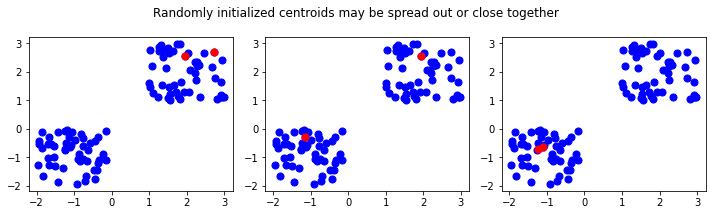

In [84]:
fig, axes = plt.subplots(1,3,figsize=(10,3))
fig.suptitle('Randomly initialized centroids may be spread out or close together')
axes[0].scatter(X[ : , 0], X[ :, 1], s = 50, c = 'b')
axes[0].scatter(random_cent[0][:,0],random_cent[0][:,1], s = 50, c = 'r')

axes[1].scatter(X[ : , 0], X[ :, 1], s = 50, c = 'b')
axes[1].scatter(random_cent[1][:,0],random_cent[1][:,1], s = 50, c = 'r')

axes[2].scatter(X[ : , 0], X[ :, 1], s = 50, c = 'b')
axes[2].scatter(random_cent[2][:,0],random_cent[2][:,1], s = 50, c = 'r')

plt.tight_layout()
plt.show()

**Kmeans++ initialized centroids** (more likely to be spread out): 

The method improves upon randomly selected centroids by:
 - Initializing only first centroid randomly
 - Next centroids are chosen by maximizing the distance to already initialized centroids

In [76]:
kmpp_cent = [select_centroids(X,2) for _ in range(3)]

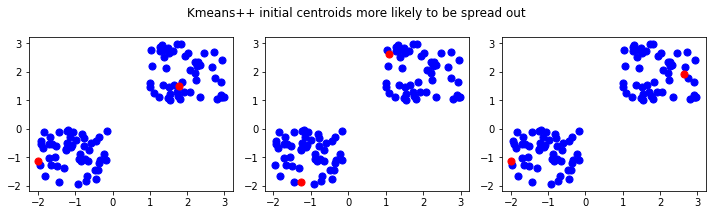

In [85]:
fig, axes = plt.subplots(1,3,figsize=(10,3))
fig.suptitle('Kmeans++ initial centroids more likely to be spread out')
axes[0].scatter(X[ : , 0], X[ :, 1], s = 50, c = 'b')
axes[0].scatter(kmpp_cent[0][:,0],kmpp_cent[0][:,1], s = 50, c = 'r')

axes[1].scatter(X[ : , 0], X[ :, 1], s = 50, c = 'b')
axes[1].scatter(kmpp_cent[1][:,0],kmpp_cent[1][:,1], s = 50, c = 'r')

axes[2].scatter(X[ : , 0], X[ :, 1], s = 50, c = 'b')
axes[2].scatter(kmpp_cent[2][:,0],kmpp_cent[2][:,1], s = 50, c = 'r')

plt.tight_layout()
plt.show()

### K-means clustering is a simple

Below is the output of my kmeans function on a clearly disjoint dataset.

In [90]:
centroids,labels = kmeans(X, 2,init_centroids='kmeans++')

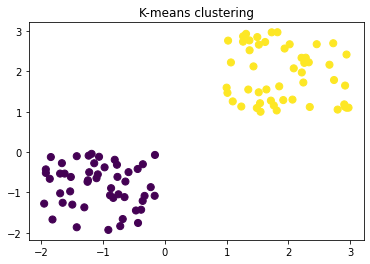

In [93]:
plt.scatter(X[ : , 0], X[ :, 1], s = 50, c = labels)
plt.title('K-means clustering')
plt.show()

## Model Evaluation

Because the true groupings of data points is often unknown, clustering algorithms can be hard to evaluate. There is no "Y True" value to compare to the predicted labels. 

One way to test the effectiveness of the kmeans algorithm is to test the clustering labels on a dataset for which the number of clusters is known. The breast cancer dataset shown below has 2 labels: cancer and benign.

In [7]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [8]:
# Load data and scale so distances among variables can be compared
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target
sc = StandardScaler()
X = sc.fit_transform(X)

In [18]:
# Because there are two labels, cluster data into 2 groups.
centroids, labels = kmeans(X, k=2, init_centroids='kmeans++', tolerance=.01)
df = pd.DataFrame({'y_true':y,'label':labels})
df.head()

,y_true,label
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


In [10]:
# Assumed true label for clusters
neg = df[df['label']==0]['y_true'].value_counts().idxmax()
pos = df[df['label']==1]['y_true'].value_counts().idxmax()
neg,pos

(1, 0)

In [11]:
# Labels may need to be flipped since kmeans chooses cluster labels of 0 and 1 arbitrarily
df.loc[df['label']==0,'label_flip']= neg
df.loc[df['label']==1,'label_flip']= pos
df['label_flip'] = df['label_flip'].astype('int32')

In [12]:
# Get confusion matrix values
pred_false = df[df['label_flip']==0]['y_true'].value_counts().rename('pred F')
pred_true = df[df['label_flip']==1]['y_true'].value_counts().rename('pred T')

In [15]:
# Create confusion matrix df
conf_mtx = pd.concat([pred_false,pred_true],axis=1)
conf_mtx = conf_mtx.set_index([pd.Index(['Actual False','Actual True'])])

In [16]:
# Calculate accuracy
TN, TP = conf_mtx.iloc[0,0], conf_mtx.iloc[1,1]
acc = (TN + TP) / len(df)

In [17]:
print('clustering accuracy: ', round(acc,3))
conf_mtx

clustering accuracy:  0.912


,pred F,pred T
Actual False,175,37
Actual True,13,344


The confusion matrix shows that kmeans did fairly well clustering the data points into the correct labels of cancer and non-cancer with an accuracy of 0.91.

## Issues with k-means

K-means does not perform well on disjoint, nested structures. This can be ameliorated using algorithms other than kmeans like spectral clustering.

https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py

In [5]:
# from kmeans import *
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt

[[-0.01232336  0.28864315]
 [ 0.02914158 -0.52815232]]


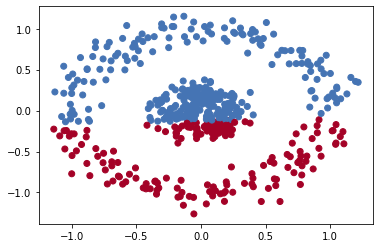

In [6]:
X, _ = make_circles(n_samples=500, noise=0.1, factor=.2)
centroids, labels = kmeans(X, 2, init_centroids='kmeans++')
print(centroids)
colors=np.array(['#4574B4','#A40227'])
plt.scatter(X[:,0], X[:,1], c=colors[labels])
plt.show()

## Application to Image Compression

Images can be easily compressed using k-means to group similar colors. Each pixel in an image is a 3 dimensional array associated with RGB values. Pixels can be grouped by cluster and relabeled to reduce the number of bytes needed to represent the image.

In [24]:
from sklearn.utils import shuffle
from sklearn.metrics import pairwise_distances_argmin
from skimage.io import imread
from time import time
from PIL import Image

In [35]:
def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

### Compression of small image

In [59]:
# 40x115 pixel image
eyes = imread('/Users/elysecs/Desktop/eyes.png')
eyes.shape

(40, 115, 3)

In [60]:
# Example pixels
w,h,d = eyes.shape
pixels = np.reshape(eyes, (w*h,d))
pixels[:2]

array([[55, 51, 52],
       [55, 49, 51]], dtype=uint8)

In [61]:
# 3681 colors out of the millions of possibilities (256^3)!
len(np.unique(pixels,axis=0))

3681

In [62]:
# Change RGB values to floats and put in range [0,1]
eyes_fl = np.array(eyes, dtype=np.float64)/255

In [63]:
image_arr = np.reshape(eyes_fl, (w*h,d))
assert len(image_arr)==w*h
len(image_arr)

4600

In [64]:
# Choose number of colors for compression
t0 = time()
n_colors=4
centroids, labels = kmeans(image_arr, k=n_colors, init_centroids='kmeans++',max_iter=30)
print("done in %0.3fs." % (time() - t0))

# Random colors
codebook_random = shuffle(image_arr, random_state=0)[:n_colors]
t0 = time()
labels_random = pairwise_distances_argmin(codebook_random,
                                          image_arr,
                                          axis=0)
print("done in %0.3fs." % (time() - t0))

done in 1.046s.
done in 0.001s.


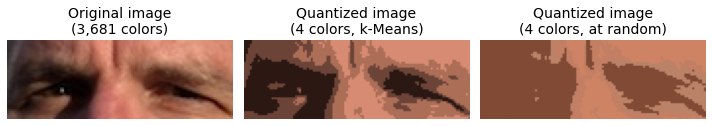

In [65]:
fig, axes = plt.subplots(1,3,figsize=(10,10))
axes[0].axis('off')
axes[0].set_title(f'Original image\n(3,681 colors)', fontsize=14)
axes[0].imshow(eyes)

axes[1].axis('off')
axes[1].set_title(f'Quantized image\n({n_colors} colors, k-Means)', fontsize=14)
axes[1].imshow(recreate_image(centroids, labels, w, h))

axes[2].axis('off')
axes[2].set_title(f'Quantized image\n({n_colors} colors, at random)', fontsize=14)
axes[2].imshow(recreate_image(codebook_random, labels_random, w, h))
plt.tight_layout()
plt.show()

The small image, originally 3,681 colors, can be summarised with only 4 colors. The image produced by the kmeans colors better captures the likeness of the original picture than the randomly  chosen colors.

### Compression of Wikipedia autumn image

In [67]:
pic = imread('/Users/elysecs/Desktop/autumn.jpg')
w,h,d = pic.shape
pic_fl = np.array(pic, dtype=np.float64)/255
pic_arr = np.reshape(pic_fl, (w*h,d))
pic.shape

(427, 640, 3)

In [70]:
# Number of colors in original picture
w,h,d = pic.shape
pixels = np.reshape(pic, (w*h,d))
og_ncolors = len(np.unique(pixels,axis=0))
og_ncolors

125080

In [69]:
# Choose number of colors for compression
t0 = time()
n_colors=10
centroids, labels = kmeans(pic_arr, k=n_colors, init_centroids='kmeans++',max_iter=30)

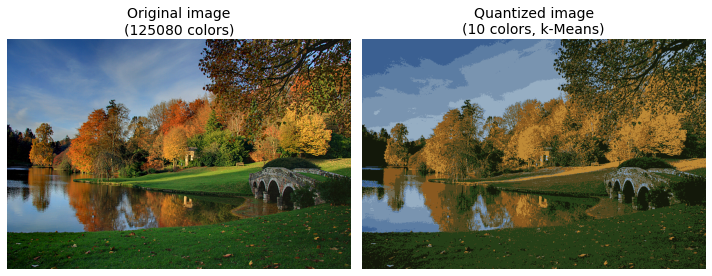

In [72]:
fig, axes = plt.subplots(1,2,figsize=(10,10))
axes[0].axis('off')
axes[0].set_title(f'Original image\n({og_ncolors} colors)', fontsize=14)
axes[0].imshow(pic)

axes[1].axis('off')
axes[1].set_title(f'Quantized image\n({n_colors} colors, k-Means)', fontsize=14)
axes[1].imshow(recreate_image(centroids, labels, w, h))
plt.tight_layout()
plt.show()

Again, the kmeans colors capture the likeness of the original photo well with only a fraction of the colors needed.

## Conclusion
K-means can be computationally expensive as it loops through the data multiple times. The results may also be difficult to interpret as clusters and number of clusters are not easy to disambiguate. However, because it can be useful as a first step to understand data and is a simple algorithm to understand, it is a useful tool in the data science toolbox.